# CSCI 4622 Final Project 

## Imports Necessary Libraries

In [1]:
# ---------- Import Essential Libraries ---------- #

# Machine Learning Essentials #
#import kaggle  uncomment if running locally
#%pip install grad-cam


import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os 
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model 
import cv2

# import splitfolders 
import pathlib
from pathlib import Path

# Python Utils #
import copy


## If running on local machine, use Kaggle API with the code in the cell below to get the right directory structure

In [2]:
# kaggle.api.authenticate()

# kaggle.api.dataset_download_files('preetviradiya/brian-tumor-dataset', path='data', unzip=True)
# kaggle.api.dataset_metadata('preetviradiya/brian-tumor-dataset', path='.')

## Inputs and Folders

In [3]:
# Globals / Settings
KAGGLE_INPUT   = '/kaggle/input'
DATA_METADATA  = '/kaggle/input/brian-tumor-dataset/metadata.csv'
DATA_DIRECTORY = '/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set'


# Run cell below if working in Kaggle
## Read in data and make a dataframe with the filepaths and labels associated with said file path


In [4]:
# Define the directories and labels for both folders of images 

directories = {
    "Brain Tumor": '/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor',
    "Healthy":  '/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Healthy'
}

# Create list of filepaths and a list of labels 
filepaths = []
labels = [] 

# Iterate through the directories and collect the file paths and labels 
for label, path in directories.items():
    for name in os.listdir(path):
        filepaths.append(os.path.join(path, name))
        labels.append(label)


# Create a dataframe with the file paths and the labels 

df = pd.DataFrame({"filepaths": filepaths, "labels": labels})




In [5]:
test_filepaths = filepaths[2]
print(f"test_filepaths: {test_filepaths}\n")

test_labels = labels[2:20]
print(f"test_labels: {test_labels}\n")

test_filepaths: /kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (2411).jpg

test_labels: ['Brain Tumor', 'Brain Tumor', 'Brain Tumor', 'Brain Tumor', 'Brain Tumor', 'Brain Tumor', 'Brain Tumor', 'Brain Tumor', 'Brain Tumor', 'Brain Tumor', 'Brain Tumor', 'Brain Tumor', 'Brain Tumor', 'Brain Tumor', 'Brain Tumor', 'Brain Tumor', 'Brain Tumor', 'Brain Tumor']



# Run cell below if working locally 
## Note this requires the Kaggle API to get the directory structure required

In [6]:
# # Define the directories and labels for both folders of images 

# directories = {
#   "Brain Tumor":'./data/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor',
#   "Healthy":'./data/Brain Tumor Data Set/Brain Tumor Data Set/Healthy'
# }

# # Check if Files Exist
# print(os.path.exists('./data/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor'))
# print(os.path.exists('./data/Brain Tumor Data Set/Brain Tumor Data Set/Healthy'))

# # Create list of filepaths and a list of labels 
# filepaths = []
# labels = [] 

# # Iterate through the directories and collect the file paths and labels 
# for label, path in directories.items():
#   for name in os.listdir(path):
#     filepaths.append(os.path.join(path, name))
#     labels.append(label)


# # Create a dataframe with the file paths and the labels 

# df = pd.DataFrame({"filepaths": filepaths, "labels": labels})

In [7]:
df.head()

,filepaths,labels
0,/kaggle/input/brian-tumor-dataset/Brain Tumor ...,Brain Tumor
1,/kaggle/input/brian-tumor-dataset/Brain Tumor ...,Brain Tumor
2,/kaggle/input/brian-tumor-dataset/Brain Tumor ...,Brain Tumor
3,/kaggle/input/brian-tumor-dataset/Brain Tumor ...,Brain Tumor
4,/kaggle/input/brian-tumor-dataset/Brain Tumor ...,Brain Tumor


## Split data into training, testing, and validation sets

In [8]:
train_df, test_df = train_test_split(df, test_size=0.25, random_state=43,stratify=df.labels)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=43,stratify=train_df.labels)

print(f"Training set is of shape {train_df.shape}")
print(f"Testing set is of shape {test_df.shape}")
print(f"Validation set is of shape {val_df.shape}")



Training set is of shape (2932, 2)
Testing set is of shape (1150, 2)
Validation set is of shape (518, 2)


# Preprocess Images 

# Data Generators (Batching, Data Augmentation, On-the-fly-processing, and flow control) 

In [9]:
# Use tensorflows ImageDataGenerator to preprocess the images 

# rescale parameter will scale pixel values to the range [0,1] 
image_generator = ImageDataGenerator(
    rescale=1./255 # Normalize image pixel values from [0,255] to [0,1]
)

# Create a data generator for the training set
train = image_generator.flow_from_dataframe(
    dataframe=train_df,         # DataFrame containing file paths and labels for training data
    x_col="filepaths",          # Column in the DataFrame with the file paths to the images
    y_col="labels",             # Column in the DataFrame with the labels for the images
    target_size=(256, 256),     # Resize all images to 256x256 pixels
    color_mode='rgb',           # Load images in RGB format (3 color channels)
    class_mode="categorical",   # Generate one-hot encoded labels for multi-class classification
    batch_size=64,              # Number of images to generate per batch
    shuffle=True               # Shuffle images 
)

# Create a data generator for the test set
test = image_generator.flow_from_dataframe(
    dataframe=test_df,          # DataFrame containing file paths and labels for test data
    x_col="filepaths",          # Column in the DataFrame with the file paths to the images
    y_col="labels",             # Column in the DataFrame with the labels for the images
    target_size=(256, 256),     # Resize all images to 256x256 pixels
    color_mode='rgb',           # Load images in RGB format
    class_mode="categorical",   # Generate one-hot encoded labels for evaluation
    batch_size=64,              # Number of images to generate per batch
    shuffle=False               # Do not shuffle the order, as this is for testing
)

# Create a data generator for the validation set
val = image_generator.flow_from_dataframe(
    dataframe=val_df,           # DataFrame containing file paths and labels for validation data
    x_col="filepaths",          # Column in the DataFrame with the file paths to the images
    y_col="labels",             # Column in the DataFrame with the labels for the images
    target_size=(256, 256),     # Resize all images to 256x256 pixels
    color_mode='rgb',           # Load images in RGB format
    class_mode="categorical",   # Generate one-hot encoded labels for validation
    batch_size=64,              # Number of images to generate per batch
    shuffle=False               # Do not shuffle the order, as this is for validation
)


Found 2932 validated image filenames belonging to 2 classes.
Found 1150 validated image filenames belonging to 2 classes.
Found 518 validated image filenames belonging to 2 classes.


# Examples from dataset



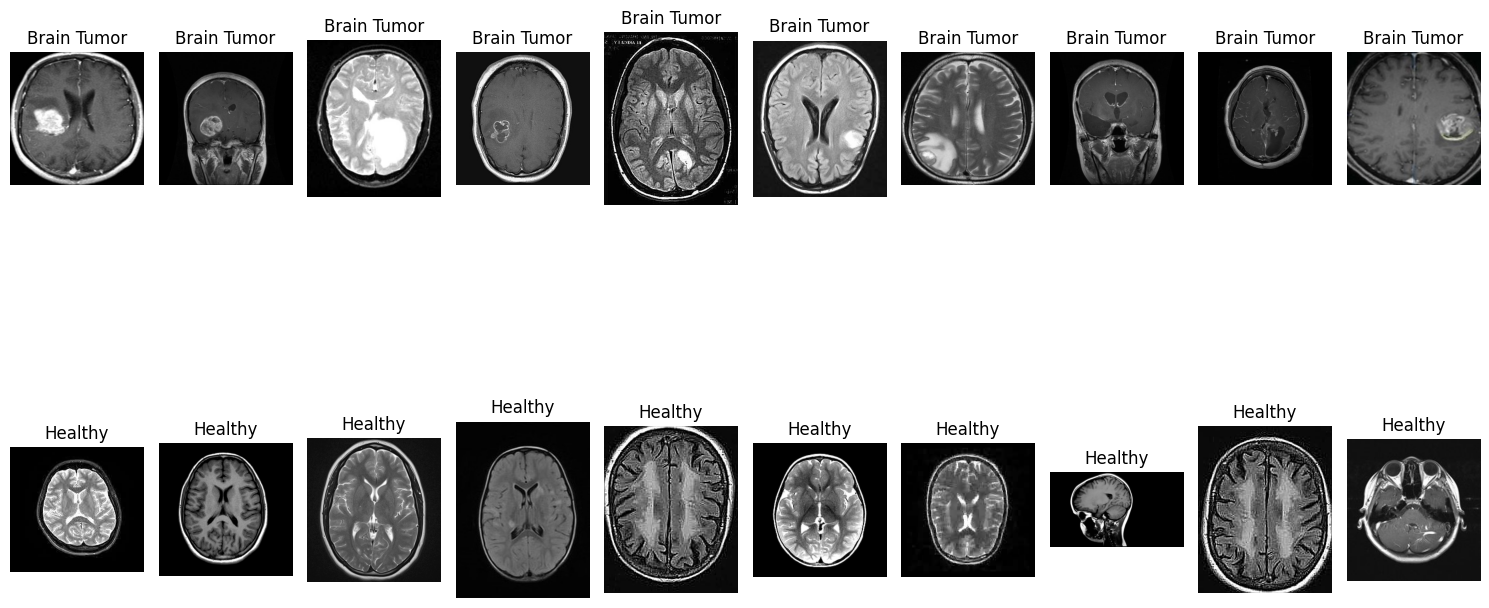

In [10]:
# Arbritrary number of images from each class in the dataset 
images_per_class = 10

# Get class labels
class_labels = train.class_indices.keys()

# Initialize plot 
plt.figure(figsize=(15, 10))

# Plot images for each class
for label_index, label in enumerate(class_labels):
    # Get the filepaths of the current class 
    filepaths = train_df.loc[train_df['labels'] == label, 'filepaths']
    
    # Randomly select images to display
    selected_filepaths = np.random.choice(filepaths, min(images_per_class, len(filepaths)), replace=False)
    
    # Plot the images
    for i, filepath in enumerate(selected_filepaths):
        plt_idx = label_index * images_per_class + i + 1
        plt.subplot(len(class_labels), images_per_class, plt_idx)
        plt.imshow(plt.imread(filepath))
        plt.title(label)
        plt.axis('off')

plt.tight_layout()
plt.show()


# Create CNN and Compile the Model 

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the CNN model
# Using a sequential model with 3 convolutional layers
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),  # First Conv Layer
    MaxPooling2D((2, 2)),                                               # Max Pooling
    Conv2D(64, (3, 3), activation='relu'),                              # Second Conv Layer
    MaxPooling2D((2, 2)),                                               # Max Pooling
    Conv2D(128, (3, 3), activation='relu'),                             # Third Conv Layer
    MaxPooling2D((2, 2)),                                               # Max Pooling
    Flatten(),                                                          # Flatten the output
    Dense(128, activation='relu'),                                      # Fully Connected Layer
    Dropout(0.5),                                                       # Dropout for regularization
    Dense(len(train.class_indices), activation='softmax')               # Output layer with softmax activation
])

# Compile the model
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',   # Since it's multi-class classification
    metrics=['accuracy']
)

# Summary of the model architecture
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,234 (56.61 MB)

 Trainable params: 14,839,234 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

# Train the Model

In [12]:
# Train the model
history = model.fit(
    train,                           # Training data
    epochs=20,                        # Number of epochs
    validation_data=val,              # Validation data
    steps_per_epoch=train.samples // train.batch_size,    # Steps per epoch
    validation_steps=val.samples // val.batch_size,        # Validation steps
    verbose=1
)

# Save the trained model (optional)
model.save('cnn_model.h5')


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733899236.454325      69 service.cc:145] XLA service 0x7d321c005060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733899236.454385      69 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733899236.454389      69 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 2/45 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.5273 - loss: 2.4444 

I0000 00:00:1733899249.042439      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/45 ━━━━━━━━━━━━━━━━━━━━ 48s 690ms/step - accuracy: 0.6154 - loss: 1.2965 - val_accuracy: 0.7676 - val_loss: 0.4920
Epoch 2/20
 1/45 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.7500 - loss: 0.4554

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7500 - loss: 0.4554 - val_accuracy: 1.0000 - val_loss: 0.1608
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 271ms/step - accuracy: 0.8317 - loss: 0.3931 - val_accuracy: 0.8223 - val_loss: 0.3966
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - accuracy: 0.9062 - loss: 0.2128 - val_accuracy: 1.0000 - val_loss: 0.1047
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 258ms/step - accuracy: 0.9036 - loss: 0.2568 - val_accuracy: 0.8945 - val_loss: 0.2882
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - accuracy: 0.9062 - loss: 0.2317 - val_accuracy: 1.0000 - val_loss: 0.0509
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 313ms/step - accuracy: 0.9427 - loss: 0.1608 - val_accuracy: 0.9199 - val_loss: 0.2464
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - accuracy: 0.9688 - loss: 0.0793 - val_accuracy: 1.0000 - val_loss: 0.0137
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 239ms/step - accuracy: 0.9606 - loss: 0.1136 - val_accuracy: 0.9336 - v

In [13]:
loss, accuracy = model.evaluate(test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 749ms/step - accuracy: 0.9759 - loss: 0.1447
Test Loss: 0.12568368017673492
Test Accuracy: 0.9730435013771057


## Create plots of training and validation accuracy as a fucntion of the number of Epochs as well as training and validation as a function of the number of epochs

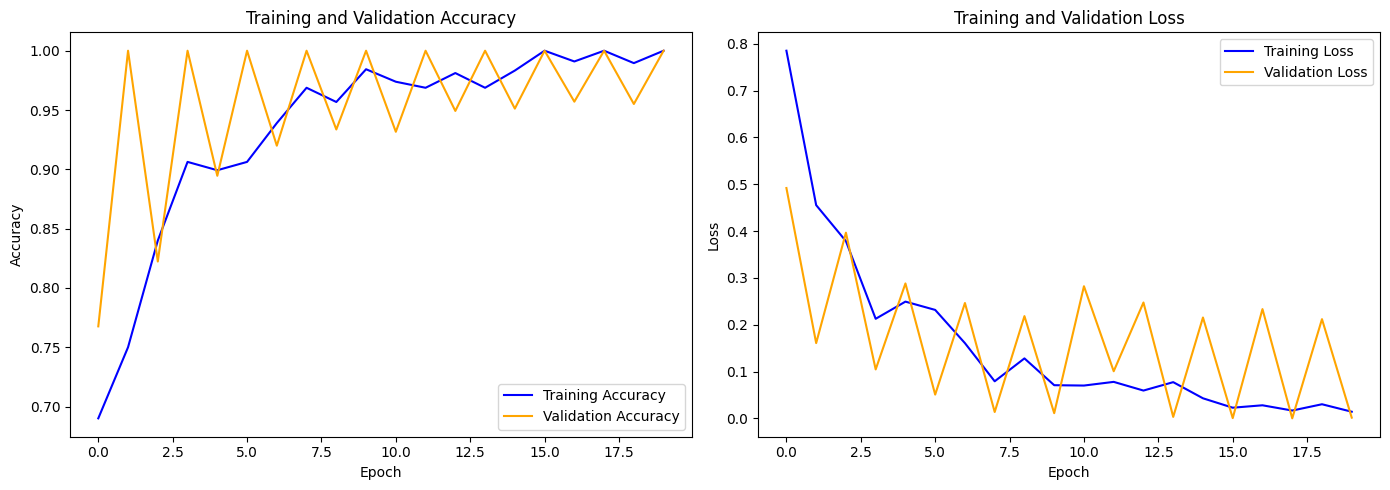

In [14]:
# Retrieve accuracy and loss data from history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a figure with two subplots: one for accuracy and one for loss
plt.figure(figsize=(14, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()


# Create Confusion Matrix


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 261ms/step


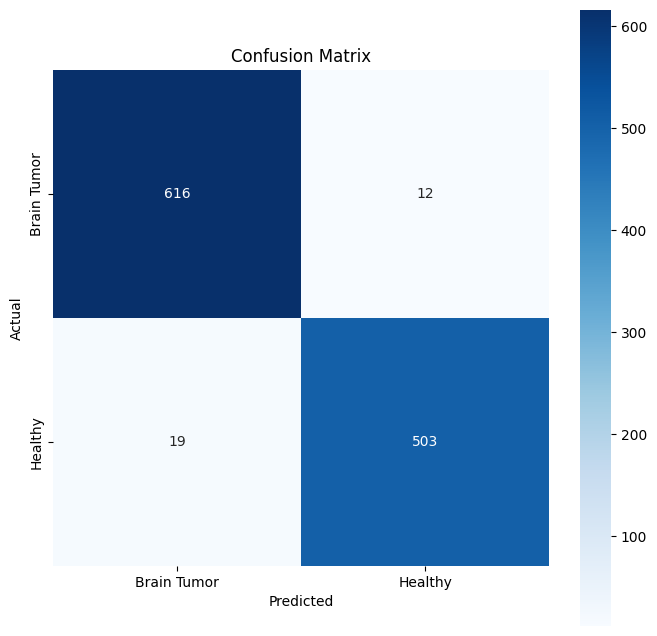

In [15]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions for the test data
y_pred = model.predict(test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels for the test data
true_classes = test.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True, 
            xticklabels=test.class_indices.keys(), yticklabels=test.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## What we know so far: 
The model is working and it is around 97.8% accurate with 20 epochs. 

# TODO Add Grad CAM section

# Load the trained model 

In [16]:
from tensorflow.keras.models import load_model

# Load the trained model
try:
    # Load the trained model
    from tensorflow.keras.models import load_model
    model = load_model('cnn_model.h5')

    # List all layer names
    print("Listing all layers in the model:")
    for i, layer in enumerate(model.layers):
        print(f"Layer {i}: Name = {layer.name}, Type = {type(layer).__name__}")
    
    # Find the last Conv2D layer
    last_conv2d_layer = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv2d_layer = layer.name
            break
    
    if last_conv2d_layer:
        print(f"\nLast Conv2D layer: {last_conv2d_layer}")
    else:
        print("\nNo Conv2D layer found in the model.")
except Exception as e:
    print(f"An error occurred: {e}")

Listing all layers in the model:
Layer 0: Name = conv2d, Type = Conv2D
Layer 1: Name = max_pooling2d, Type = MaxPooling2D
Layer 2: Name = conv2d_1, Type = Conv2D
Layer 3: Name = max_pooling2d_1, Type = MaxPooling2D
Layer 4: Name = conv2d_2, Type = Conv2D
Layer 5: Name = max_pooling2d_2, Type = MaxPooling2D
Layer 6: Name = flatten, Type = Flatten
Layer 7: Name = dense, Type = Dense
Layer 8: Name = dropout, Type = Dropout
Layer 9: Name = dense_1, Type = Dense

Last Conv2D layer: conv2d_2


### Create GRAD-CAM function

In [17]:
def grad_cam(model, img_array, class_index): 
    """
    Generate a GRAD_CAM heatmap for a specific class 
    
    Parameters:
    - model: Trained CNN model 
    - img_array: Preprocessed image array of shape (1, height, width, channels)
    _ class_index: Index of class of image to visualize 

    Returns: 
    - heatmap: Grad_Cam heatmap
    """
    model = load_model('cnn_model.h5')

    # Get last convolutional layer in model 
    last_conv_layer = model.get_layer('conv2d_8')

    # Create model mapping the input to the activations of the last conv layer
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [last_conv_layer.output, model.output]
    )

    # Compute the gradient of the class output w.r.t feature map 
    with tf.GradientTape() as tape: 
        conv_outputs, predictions = grad_model(img_array)

    # Extract the gradients of the loss w.r.t the feature map 
    grads = tape.gradient(loss, conv_outputs)

    # Compute the mean intensity of the gradients along the channels 
    weights = tf.reduce_mean(grads, axis=(0,1,2))

    # Create the weighted combination of the feature map activations 
    cam = np.sum(weights * conv_outputs[0], axis=-1)

    # Apply ReLU to filter out negative values
    cam = np.maximum(cam,0)

    # Normalize heatmap 
    heatmap = cam / np.max(cam) if np.max(cam) != 0 else cam 

    return heatmap

    
    

### Visualize heatmap 

In [18]:
def display_grad_cam(img_path, heatmap, alpha=0.4):
    """
    Overlay GRAD_CAM heatmap on the original image 

    Parameters: 
    - img_path: Path to the original image. 
    _ heatmap: Grad_CAM heatmap. 
    _ alpha: Transparency factor for the overlay. 
    """

    # Load the original image 
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Resize the heatmap to match original images
    heatmap = np.uint8(255 * heatmap)
    heatmap = tf.image.resize(heatmap, (img.shape[0], img.shape[1])).numpy() 

    # Apply a colormap to the heatmap 
    heatmap = plt.cm.jet(heatmap)[:,:,:3]

    # Overlay the heatmap on the image 
    superimposed_img = heatmap * alpha + img / 255.0 

    # Display the image 
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

## Load and preprocess images for Grad_Cam

In [19]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
img_path = test_df.iloc[0]['filepaths']  # Get the file path of an image
label_name = test_df.iloc[0]['labels']  # Get the corresponding label

# Load and preprocess the image
img = load_img(img_path, target_size=(256, 256))  # Resize image to model input size
img_array = img_to_array(img)                     # Convert to array
img_array = np.expand_dims(img_array, axis=0)     # Add batch dimension
img_array = img_array / 255.0                     # Normalize to [0, 1]

class_indices = {
    "Brain Tumor": 0,
    "Healthy": 1
}


print(f"img_array = {img_array}")
print(f"class_indicies = {class_indices}")

img_array = [[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]]
class_indicies = {'Brain Tumor': 0, 'Healthy': 1}


# Apply Grad-CAM to Test Images

In [20]:
# # Ensure the model has been called at least once
# dummy_input = tf.random.normal((1, 256, 256, 3))  # Create a dummy input
# _ = model(dummy_input)  # Pass dummy input through the model

# # Load and preprocess an image
# img_path = test_df.iloc[0]['filepaths']
# label_name = test_df.iloc[0]['labels']
# img = load_img(img_path, target_size=(256, 256))
# img_array = img_to_array(img) / 255.0
# img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# # Map label to class index
# class_index = class_indices[label_name]

# # Generate and display Grad-CAM
# heatmap = grad_cam(model, img_array, class_index)
# display_grad_cam(img_path, heatmap)

